In [1]:
# from https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

import pandas as pd
import sklearn as sk
import numpy as np

In [2]:
df = pd.read_csv('./sns.csv')

In [3]:
df.head()

,Item,Category,Subcategory
0,nabisco instant cream of wheat hot cereal 12 c...,breakfast-cereal,breakfast-cereal
1,swiffer wet mopping cloths febreze lavender 24...,laundry-paper-cleaning,household-cleaners
2,hartz duraplay medium dog toy bone bacon scent...,pet-store,dog-treats-toys
3,stouffers classics macaroni beef 127 oz box,frozen,frozen-meals-entrees-sides
4,lean cuisine favorites lasagna with meat sauce...,frozen,frozen-meals-entrees-sides


In [4]:
# create mappings etween category and category id
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head(200)

,Item,Category,Subcategory,category_id
0,nabisco instant cream of wheat hot cereal 12 c...,breakfast-cereal,breakfast-cereal,0
1,swiffer wet mopping cloths febreze lavender 24...,laundry-paper-cleaning,household-cleaners,1
2,hartz duraplay medium dog toy bone bacon scent...,pet-store,dog-treats-toys,2
3,stouffers classics macaroni beef 127 oz box,frozen,frozen-meals-entrees-sides,3
4,lean cuisine favorites lasagna with meat sauce...,frozen,frozen-meals-entrees-sides,3
...,...,...,...,...
195,maplehurst pie lemon meringue 8 inch 225 oz pkg,bread-bakery,bakery-pies-desserts,6
196,mjays specialty gourmet brownie platter smores...,bread-bakery,bakery-pies-desserts,6
197,table talk old fashioned baked cherry pie 4 oz...,bread-bakery,bakery-pies-desserts,6
198,stop shop bakery limited time holiday spice lo...,bread-bakery,bakery-pies-desserts,6


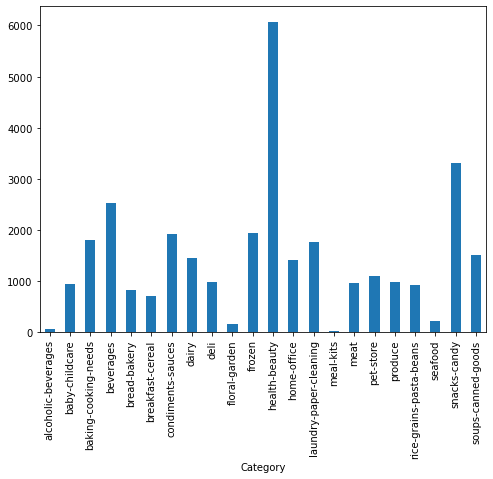

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Item.count().plot.bar(ylim=0)
plt.show()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(3, 6), stop_words='english')
features = tfidf.fit_transform(df.Item).toarray()
labels = df.category_id
features.shape

(31668, 9838)

In [9]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 4]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 5]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'alcoholic-beverages':
  . Most correlated unigrams:
. mixer ltr btl
. bloody mary mix
  . Most correlated bigrams:
. pk 12 oz btl
. beer pk 12 oz
  . Most correlated trigrams:
. regular sliced apx 12 lb
. beer pk 12 oz btl
# 'baby-childcare':
  . Most correlated unigrams:
. gerber 2nd baby
. stage baby food
  . Most correlated bigrams:
. size diapers 27 lbs
. gerber 2nd baby food
  . Most correlated trigrams:
. beech nut stage baby food
. size diapers 22 37 lbs
# 'baking-cooking-needs':
  . Most correlated unigrams:
. olive oil extra
. jell gelatin dessert
  . Most correlated bigrams:
. taco seasoning mix packet
. olive oil extra virgin
  . Most correlated trigrams:
. pure vanilla extract oz btl
. jell instant pudding pie filling
# 'beverages':
  . Most correlated unigrams:
. 64 oz btl
. pk 12 oz
  . Most correlated bigrams:
. 12 pk 12 oz
. pk 169 oz btl
  . Most correlated trigrams:
. coffee cups 12 ct box
. tea bags 20 ct box
# 'bread-bakery':
  . Most correlated unigrams:
. bread

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Item'], df['Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [11]:
print(clf.predict(count_vect.transform(["Betty Crocker Brownie Mix Milk Chocolate Traditional, 18.4 oz"])))

['baking-cooking-needs']
